In [21]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
use_gpu = torch.cuda.is_available()
print(device)

cpu


# Initialize for CPU & GPU

In [22]:
if use_gpu:
    !pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric --no-index --find-links=file:///kaggle/input/torch-geometric
#     !pip install torch_geometric_temporal  
else:
#     !pip uninstall torch-scatter torch-sparse torch-geometric torch-cluster  --y
    !pip install torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
    !pip install torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
    !pip install torch-cluster -f https://data.pyg.org/whl/torch-{torch.__version__}.html
    !pip install git+https://github.com/pyg-team/pytorch_geometric.git
#     !pip install torch_geometric_temporal


Looking in links: https://data.pyg.org/whl/torch-2.0.0+cpu.html
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cpu.html
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cpu.html
  Cloning https://github.com/pyg-team/pytorch_geometric.git to /tmp/pip-req-build-77887u2p
  Running command git clone --filter=blob:none --quiet https://github.com/pyg-team/pytorch_geometric.git /tmp/pip-req-build-77887u2p
  Resolved https://github.com/pyg-team/pytorch_geometric.git to commit e8f752ff6aae828a5f70d7d53324cfbc4302092f
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


# Import

In [23]:
from torch.profiler import profile, record_function, ProfilerActivity
import torch.autograd.profiler as profiler

In [24]:
import numpy as np
import pandas as pd
import os
import re
import json
from scipy.special import perm
from itertools import combinations,chain
from typing import List, Union
from torch_geometric.data import Data
from sklearn.preprocessing import OneHotEncoder

import matplotlib.pyplot as plt
import pickle
import time
from torch import nn
from torch.nn import Linear as Lin
from torch.nn import ReLU, LeakyReLU
from torch.nn import Sequential as Seq
import torch.nn.functional as F
from torch_geometric.nn import GINEConv
from torch import autograd
from torch_geometric.nn.models import InnerProductDecoder
from torch_geometric.utils import to_dense_adj

from sklearn.model_selection import train_test_split

In [25]:
# edge_net = Lin(5,25)
# test = NNConv(5,5,nn=edge_net)

# nn.init.ones_(test.lin.weight)
# nn.init.ones_(edge_net.weight)
# nn.init.zeros_(edge_net.bias)

# print(test.lin.weight)
# print(edge_net.weight)
# print(edge_net.bias)

# x = torch.FloatTensor([
#     [0,0,0,0,0],
#     [1,2,3,4,5],
#     [1,2,3,4,5],
# ])

# edge_index = torch.LongTensor([
#     [0,1],
#     [1,2]
# ])

# edge_attr = torch.FloatTensor([
#     [1,1,1,1,1],
#     [2,2,2,2,2],
# #     [3,3,3,3,3],
# ])

# test(x,edge_index,edge_attr)

# DataLoader

In [26]:
Edge_Flag = List[Union[np.ndarray, None]]
Edge_Index = List[Union[np.ndarray, None]]
Edge_Attr = List[Union[np.ndarray, None]]

Node_Flag = List[Union[np.ndarray, None]]
Node_Index = List[Union[np.ndarray, None]]
Node_Attr = List[Union[np.ndarray, None]]
Additional_Attr = List[np.ndarray]



class GraphSignal(object):
    # dynamic node static node attr dynamic edge and edge attr
    def __init__(
        self,
        edge_flag: Edge_Flag,
        edge_index: Edge_Index,
        edge_attr: Edge_Attr,
        node_flag: Node_Flag,
        node_index: Node_Index,
        node_attr: Node_Attr,
        ts_list: List,
    ):
        
        self.edge_flag = torch.LongTensor(edge_flag)
        self.edge_index = torch.LongTensor(edge_index).T
        self.edge_attr = edge_attr
        self.node_flag = torch.LongTensor(node_flag)
        self.node_index = torch.LongTensor(node_index).to(device)
        self.node_attr = node_attr
        self.ts_list = ts_list
        self.edge_attr_encoded = None
        self.node_attr_encoded = None
        self.edge_index_agg = None
        self.edge_attr_agg = None
        self.edge_flag_agg = None
        
        self._set_snapshot_count()

    def _set_snapshot_count(self):
        self.snapshot_count = len(self.edge_flag)
    
    def encode_edge_attr(self, enocder):
        self.edge_attr_encoded = torch.FloatTensor(enocder.transform(self.edge_attr))
    
    def encode_node_attr(self, enocder):
        self.node_attr_encoded = torch.FloatTensor(enocder.transform(self.node_attr)).to(device)
        
    def aggregate_edge_attr(self):
        if self.edge_attr_encoded is None:
            print("Edge Attr Need to be Encoded!")
            raise
        edge_index = self.edge_index
        edge_attr = self.edge_attr_encoded
        edge_flag = self.edge_flag[:-1]
        
        edge_index_split = torch.tensor_split(edge_index, edge_flag, dim=1)
        edge_attr_split = torch.tensor_split(edge_attr, edge_flag)

        base = 0
        new_flag = []
        new_edge_index = []
        new_edge_attr = []
        for i_snapshot, (_edge_index, _edge_attr) in enumerate(zip(edge_index_split, edge_attr_split)):
            if _edge_index.shape[1] != _edge_attr.shape[0]:
                print(i_snapshot, edge_index.shape, _edge_attr.shape)
                raise
            if _edge_index.shape[1] > 0:
                index_dict = {}
                for i_edge in range(_edge_index.shape[1]):
                    index_tuple = tuple(_edge_index[:,i_edge].tolist())
                    if index_tuple in index_dict:
                        index_dict[index_tuple] += [i_edge]
                    else:
                        index_dict[index_tuple] = [i_edge]

                _new_edge_index = []
                _new_edge_attr = []
                for key in index_dict.keys():
                    _new_edge_index.append(key)
#                     print(index_dict[key])
                    _new_edge_attr.append(torch.sum(_edge_attr.index_select(0, torch.LongTensor(index_dict[key])),dim=0).unsqueeze(0))

                _new_edge_index = torch.LongTensor(_new_edge_index).T
                _new_edge_attr = torch.cat(_new_edge_attr,dim=0)
                base += _new_edge_index.shape[1]
                new_edge_index.append(_new_edge_index)
                new_edge_attr.append(_new_edge_attr)
            new_flag.append(base)
            
        new_flag = torch.LongTensor(new_flag)
        new_edge_index = torch.cat(new_edge_index,dim=1)
        new_edge_attr = torch.cat(new_edge_attr,dim=0)
        
        self.edge_flag_agg = new_flag
        self.edge_index_agg = new_edge_index.to(device)
        self.edge_attr_agg = new_edge_attr.to(device)
        
    def _get_edge_index(self, time_index: int):
        if time_index == 0:
            _start = 0
        else:
            _start = self.edge_flag[time_index-1]
        _end = self.edge_flag[time_index]
        _edge_index = self.edge_index[:,_start:_end]
        return _edge_index

    # def _get_edge_weight(self, time_index: int):
    #     if self.edge_weights[time_index] is None:
    #         return self.edge_weights[time_index]
    #     else:
    #         return torch.FloatTensor(self.edge_weights[time_index])

    def _get_edge_attr(self, time_index: int):
        if self.edge_attr_encoded is None:
            print("Edge Attr Need to be Encoded!")
            raise
        if time_index == 0:
            _start = 0
        else:
            _start = self.edge_flag[time_index-1]
        _end = self.edge_flag[time_index]
        _edge_attr = self.edge_attr_encoded[_start:_end]
        return _edge_attr
    
    def _get_node_index_attr(self, time_index: int):
        if self.node_attr_encoded is None:
            print("Node Attr Need to be Encoded!")
            raise
        if time_index == 0:
            _start = 0
        else:
            _start = self.node_flag[time_index-1]
        _end = self.node_flag[time_index]
        _node_index = self.node_index[_start:_end]
        _node_attr = self.node_attr_encoded[_node_index]
        return _node_index,_node_attr
    
    def _get_timestamp(self, time_index: int):
        _timestamp = self.ts_list[time_index]
        return _timestamp


    def __getitem__(self, time_index: int):
        edge_index = self._get_edge_index(time_index)
        edge_attr = self._get_edge_attr(time_index)
        node_index,node_attr = self._get_node_index_attr(time_index)
        _timestamp = self._get_timestamp(time_index)

        snapshot = Data(
            edge_index=edge_index,
            edge_attr=edge_attr,
            node_index=node_index,
            node_attr=node_attr,
            timestamp = _timestamp
        )
        return snapshot

    def __next__(self):
        if self.t < self.snapshot_count:
            snapshot = self[self.t]
            self.t = self.t + 1
            return snapshot
        else:
            self.t = 0
            raise StopIteration

    def __iter__(self):
        self.t = 0
        return self
    
    def __len__(self):
        return self.snapshot_count


class GraphDatasetLoader(object):
    def __init__(self,input_path=""):
        self.input_path = input_path
        self._read_data()
    
    def _read_data(self):
        self._dataset = np.load(self.input_path)

    def get_dataset(self): # -> DynamicGraphTemporalSignal:
        dataset = GraphSignal(
            edge_flag = self._dataset['edge_flag'],
            edge_index = self._dataset['edge_index'],
            edge_attr = self._dataset['edge_attr'],
            node_flag = self._dataset['node_flag'],
            node_index = self._dataset['node_index'],
            node_attr = self._dataset['node_attr'],
            ts_list = self._dataset['timestamp']
        )
        return dataset

# Model

## MultiNNConv

In [27]:
class MultiNNConv(torch.nn.Module):
    def __init__(
        self, 
        channels, 
        edge_channels, 
        conv_num, 
        lin_layers
    ):
        super().__init__()
        
        self.convs = nn.ModuleList()
        for _ in range(conv_num):
            mlp = Seq()
            mlp.append(Lin(channels, 32))
            mlp.append(LeakyReLU())
            mlp.append(Lin(32, 32))
            mlp.append(LeakyReLU())
            mlp.append(Lin(32, channels))
            self.convs.append(GINEConv(mlp, channels, edge_dim=edge_channels))
        

        pre_size = channels
        self.lin = Seq()
        for size in lin_layers:
            self.lin.append(Lin(pre_size,size))
            self.lin.append(LeakyReLU())
            pre_size = size
        self.lin.append(Lin(pre_size,channels))


    def forward(self, x, edge_index, edge_attr):
        out = x
        for conv in self.convs:
            out = conv(
                x=out,
                edge_index=edge_index,
                edge_attr=edge_attr,
            )
        return self.lin(out)

# Graph GRU Unit

In [28]:
class GraphGRU(torch.nn.Module):
    def __init__(
        self,
        channels: int,
        edge_channels: int,
        conv_num: List,
        lin_layers: List,
        bias: bool = True,
    ):
        super().__init__()

        self.channels = channels
        self.edge_channels = edge_channels
        self.conv_num = conv_num
        self.lin_layers = lin_layers
        self.bias = bias
        self._create_parameters_and_layers()

    def _create_update_gate_parameters_and_layers(self):

        self.conv_x_z = MultiNNConv(
            channels = self.channels,
            edge_channels = self.edge_channels,
            conv_num = self.conv_num,
            lin_layers = self.lin_layers,
        )

        self.conv_h_z = MultiNNConv(
            channels = self.channels,
            edge_channels = self.edge_channels,
            conv_num = self.conv_num,
            lin_layers = self.lin_layers,
        )
        
    def _create_reset_gate_parameters_and_layers(self):

        self.conv_x_r = MultiNNConv(
            channels = self.channels,
            edge_channels = self.edge_channels,
            conv_num = self.conv_num,
            lin_layers = self.lin_layers,
        )

        self.conv_h_r = MultiNNConv(
            channels = self.channels,
            edge_channels = self.edge_channels,
            conv_num = self.conv_num,
            lin_layers = self.lin_layers,
        )

    def _create_candidate_state_parameters_and_layers(self):

        self.conv_x_h = MultiNNConv(
            channels = self.channels,
            edge_channels = self.edge_channels,
            conv_num = self.conv_num,
            lin_layers = self.lin_layers,
        )

        self.conv_h_h = MultiNNConv(
            channels = self.channels,
            edge_channels = self.edge_channels,
            conv_num = self.conv_num,
            lin_layers = self.lin_layers,
        )

    def _create_parameters_and_layers(self):
        self._create_update_gate_parameters_and_layers()
        self._create_reset_gate_parameters_and_layers()
        self._create_candidate_state_parameters_and_layers()

    def _set_hidden_state(self, X, H):
        if H is None:
            H = torch.zeros(X.shape[0], self.out_channels).to(X.device)
        return H

    def _calculate_update_gate(self, X, edge_index, edge_attr, H):
        Z = self.conv_x_z(X, edge_index, edge_attr)
        Z = Z + self.conv_h_z(H, edge_index, edge_attr)
        Z = torch.sigmoid(Z)
        return Z

    def _calculate_reset_gate(self, X, edge_index, edge_attr, H):
        R = self.conv_x_r(X, edge_index, edge_attr)
        R = R + self.conv_h_r(H, edge_index, edge_attr)
        R = torch.sigmoid(R)
        return R

    def _calculate_candidate_state(self, X, edge_index, edge_attr, H, R):
        H_tilde = self.conv_x_h(X, edge_index, edge_attr)
        H_tilde = H_tilde + self.conv_h_h(H * R, edge_index, edge_attr)
        H_tilde = torch.tanh(H_tilde)
        return H_tilde

    def _calculate_hidden_state(self, Z, H, H_tilde):
        H = Z * H + (1 - Z) * H_tilde
        return H

    def forward(
            self,
            X: torch.FloatTensor,
            edge_index: torch.LongTensor,
            edge_attr: torch.FloatTensor,
            H: torch.FloatTensor = None,
        ) -> torch.FloatTensor:
        H = self._set_hidden_state(X, H)
        Z = self._calculate_update_gate(X, edge_index, edge_attr, H)
        R = self._calculate_reset_gate(X, edge_index, edge_attr, H)
        H_tilde = self._calculate_candidate_state(X, edge_index, edge_attr, H, R)
        H = self._calculate_hidden_state(Z, H, H_tilde)
        return H

# Graph GRU Layer and Global Hidden Function

In [29]:
def create_hidden(num_node, out_channels):
#     hidden_global = torch.FloatTensor(np.zeros([num_node,out_channels])).to(device)
    hidden =torch.zeros([num_node,out_channels], dtype=torch.float).to(device)
    return hidden

def select_hidden(hidden, index):
#     h = hidden_global[index] #REGULAR INDEXING
    h = hidden.index_select(dim=0, index=index) #INDEX SELECT
    return h

def update_hidden(num_node, out_channels, h, index):
#     hidden_global[index] = h.detach() #REGULAR INDEXING
#     for key,value in mapping.items():
#         hidden_global[value] = h[key] 
    hidden = torch.zeros([num_node,out_channels], dtype=torch.float).to(device)
    hidden.index_add_(0, index, h)  
    return hidden

# def update_hidden(hidden, h, index):
#     hidden.index_copy_(0, index, h)  
#     return hidden

class GraphGRULayer(torch.nn.Module):
    def __init__(
        self,
        channels: int,
        edge_channels: int,
        conv_num: int,
        lin_layers: List,
        bias: bool = True,
    ):
        super().__init__()
        self.gru = GraphGRU(
            channels = channels,
            edge_channels = edge_channels,
            conv_num = conv_num,
            lin_layers = lin_layers,
            bias = bias
        )
        
        self.channels = channels
        
    def forward(
        self,
        X: torch.FloatTensor,
        node_index: torch.LongTensor,
        node_flag: torch.LongTensor,
        edge_index: torch.LongTensor,
        edge_attr: torch.FloatTensor,
        edge_flag: torch.LongTensor,
        num_node: int,
        direction: bool # True for Forward; False for Backward
    ) -> torch.FloatTensor:
        
        X_split = torch.tensor_split(X, node_flag)
        node_index_split = torch.tensor_split(node_index, node_flag)
        edge_index_split = torch.tensor_split(edge_index, edge_flag, dim=1)
        edge_attr_split = torch.tensor_split(edge_attr, edge_flag)
        
        hidden = create_hidden(num_node, self.channels)
        
        outs = []
        if direction:
            snapshot_index = range(len(X_split))
        else:
            snapshot_index = range(len(X_split)-1,-1,-1)
        for i_snapshot in snapshot_index:
            _X = X_split[i_snapshot]
            _node_index = node_index_split[i_snapshot]
            _edge_index = edge_index_split[i_snapshot]
            _edge_attr = edge_attr_split[i_snapshot]

            _hidden = select_hidden(hidden, _node_index)
            _new_hidden = self.gru(_X, _edge_index, _edge_attr, _hidden)
            hidden = update_hidden(num_node, self.channels, _new_hidden, _node_index)
#             hidden = update_hidden(hidden, _new_hidden, _node_index)
            outs.append(_new_hidden)
        if direction:
            H = torch.cat(outs)
        else:
            H = torch.cat(outs[::-1])
        return H

## TGAE

In [30]:
class TGAE(torch.nn.Module): # Not Heterogeneous
    def __init__(
        self, 
        in_channels, 
        out_channels, 
        edge_channels, 
        node_embed_layers,
        edge_embed_layers,
        decide_layers,
        gru_conv_num, 
        gru_lin_layers
    ):
        super(TGAE, self).__init__()
        
        # Encoder
        layers = []
        pre_h_num = in_channels
        for h_num in node_embed_layers[:-1]:
#             layers.append(torch.nn.Dropout(p=0.2))
            layers.append(Lin(pre_h_num,h_num))
            layers.append(torch.nn.LeakyReLU())
            pre_h_num = h_num
        layers.append(Lin(pre_h_num,node_embed_layers[-1]))
        self.node_embed = Seq(*layers)
        
        layers = []
        pre_h_num = edge_channels
        for h_num in edge_embed_layers[:-1]:
#             layers.append(torch.nn.Dropout(p=0.2))
            layers.append(Lin(pre_h_num,h_num))
            layers.append(torch.nn.LeakyReLU())
            pre_h_num = h_num
        layers.append(Lin(pre_h_num,node_embed_layers[-1]))
        self.edge_embed = Seq(*layers)
        
        self.encoder_gru = GraphGRULayer(
            channels=node_embed_layers[-1],
            edge_channels=edge_embed_layers[-1],
            conv_num=gru_conv_num,
            lin_layers=gru_lin_layers,
        )

        layers = []
        pre_h_num = node_embed_layers[-1]
        for h_num in decide_layers:
#             layers.append(torch.nn.Dropout(p=0.2))
            layers.append(Lin(pre_h_num,h_num))
            layers.append(torch.nn.LeakyReLU())
            pre_h_num = h_num
        layers.append(Lin(pre_h_num,out_channels))
        self.decide_net = Seq(*layers)
        
        # Decoder
        
        self.decoder = InnerProductDecoder()
        

    def forward(self, x, node_index, node_flag, edge_index, edge_attr, edge_flag, num_node):
        # Encoder
        out = self.node_embed(x)
        _edge_attr = self.edge_embed(edge_attr)
        
        # GNN layer
#         with profiler.record_function("gru encoder"):
        h_encoder = self.encoder_gru(out, node_index, node_flag, edge_index, _edge_attr, edge_flag, num_node, True) 
        out = self.decide_net(h_encoder)

        return out
    

# Training

## Read Data

In [31]:
data_dir_0 = '/kaggle/input/dissertation-data'
data_dir_1 = '2021-09-11-umbrella-experiment-32run-fran'


signals = []
annotation = []
with open(os.path.join(data_dir_0, data_dir_1, "annotated.json")) as f:
    annotated_dict = json.load(f)

for data_dir_2 in os.listdir(os.path.join(data_dir_0, data_dir_1)):
    if data_dir_2 == "annotated.json":
        continue
    r = re.compile(".*.npz")
    graph_files = list(filter(r.match, os.listdir(os.path.join(data_dir_0, data_dir_1, data_dir_2))))

    if len(graph_files) > 1:
        print("Multiple Graph Files!")
        raise
    if len(graph_files) == 0:
        print("Not Found Graph File!")
        raise

    dataloader = GraphDatasetLoader(os.path.join(data_dir_0, data_dir_1, data_dir_2, graph_files[0]))
    signal = dataloader.get_dataset()
    signals.append(signal)
    annotation.append(annotated_dict[data_dir_2])

# split train and test dataset
signals_train, signals_test, annotation_train, annotation_test = train_test_split(signals, annotation, test_size=0.2, random_state=1)
signals_train, signals_val, annotation_train, annotation_val = train_test_split(signals_train, annotation_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

In [32]:
_interval = 60
_overlap = 30

node_attr_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
node_attr_encoder = node_attr_encoder.fit(np.concatenate([sample.node_attr for sample in signals_train]))

edge_attr_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
edge_attr_encoder = edge_attr_encoder.fit(np.concatenate([sample.edge_attr for sample in signals_train]))

for i_signal, signal in enumerate(signals_train):
    signal.encode_node_attr(node_attr_encoder)
    signal.encode_edge_attr(edge_attr_encoder)
    signal.aggregate_edge_attr()
    

adj_list_train = []
for signal in signals_train:
    edge_index = signal.edge_index_agg
    edge_flag = signal.edge_flag_agg[:-1]
    edge_index_split = torch.tensor_split(edge_index, edge_flag, dim=1)
    
    adj_list = [torch.clamp(to_dense_adj(_edge_index)[0], min=0, max=1) for _edge_index in edge_index_split]
    adj_list_train.append(adj_list)
    
y_train = []
for signal, annotation in zip(signals_train, annotation_train): 
    ts_list = signal.ts_list
    y = torch.zeros(signal.snapshot_count, dtype=torch.long)
    for i_ts, ts in enumerate(ts_list):
        if ts < float(annotation[1]) and float(annotation[1]) <= ts+_interval: 
            y[i_ts] = 1
    y_train.append(y)

# X_train = []
# for signal in signals_train:
# #     X_train.append(list(signal))
#     X_train.append(signal.node_attr_encoded.index_select(dim=0,index=signal.node_index))
    
# num_node_train = []
# for signal in signals_train:
#     num_node_train.append(signal.node_attr.shape[0])


    
for i_signal, signal in enumerate(signals_val):
    signal.encode_node_attr(node_attr_encoder)
    signal.encode_edge_attr(edge_attr_encoder)
    signal.aggregate_edge_attr()

adj_list_val = []
for signal in signals_val:
    edge_index = signal.edge_index_agg
    edge_flag = signal.edge_flag_agg[:-1]
    edge_index_split = torch.tensor_split(edge_index, edge_flag, dim=1)
    
    adj_list = [torch.clamp(to_dense_adj(_edge_index)[0], min=0, max=1) for _edge_index in edge_index_split]
    adj_list_val.append(adj_list)

y_val = []
for signal, annotation in zip(signals_val, annotation_val): 
    ts_list = signal.ts_list
    y = torch.zeros(signal.snapshot_count, dtype=torch.long)
    for i_ts, ts in enumerate(ts_list):
        if ts < float(annotation[1]) and float(annotation[1]) <= ts+_interval: 
            y[i_ts] = 1
    y_val.append(y)

# X_val = []
# for signal in signals_val:
# #     X_val.append(list(signal))
#     X_val.append(signal.node_attr_encoded.index_select(dim=0,index=signal.node_index))

# nums_node_val = []
# for signal in signals_val:
#     nums_node_val.append(signal.node_attr.shape[0])


    
IN_CHANNELS = signals_train[0].node_attr_encoded.shape[1]
EDGE_CHANNELS = signals_train[0].edge_attr_encoded.shape[1]

In [33]:
# for sample in X_train[:1]:
#     for snapshot in sample:
#         node_attr = snapshot.node_attr
#         node_index = snapshot.node_index
#         edge_attr = snapshot.edge_attr
#         edge_index = snapshot.edge_index
        
#         print(f"node_attr: {node_attr.shape}")
#         print(f"node_index: {node_index.shape}")
#         print(f"edge_attr: {edge_attr.shape}")
#         print(f"edge_index: {edge_index.shape}")

In [34]:
# model = torch.load(
#     "/kaggle/input/tgae-model-saved/TGAE_NNConv_50_0.0863_0.0791.model",
#     map_location=torch.device('cpu')
# )

In [35]:
model = TGAE(
    in_channels=IN_CHANNELS, 
    out_channels=8, 
    edge_channels=EDGE_CHANNELS, 
    node_embed_layers=[16,32,32],
    edge_embed_layers=[16,32,32],
    decide_layers=[32,16],
    gru_conv_num=2, 
    gru_lin_layers=[32]
)

loss_f = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)

model = model.to(device)
loss_f = loss_f.to(device)
print(model)

TGAE(
  (node_embed): Sequential(
    (0): Linear(in_features=5, out_features=16, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=16, out_features=32, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=32, out_features=32, bias=True)
  )
  (edge_embed): Sequential(
    (0): Linear(in_features=58, out_features=16, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=16, out_features=32, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=32, out_features=32, bias=True)
  )
  (encoder_gru): GraphGRULayer(
    (gru): GraphGRU(
      (conv_x_z): MultiNNConv(
        (convs): ModuleList(
          (0-1): 2 x GINEConv(nn=Sequential(
            (0): Linear(in_features=32, out_features=32, bias=True)
            (1): LeakyReLU(negative_slope=0.01)
            (2): Linear(in_features=32, out_features=32, bias=True)
            (3): LeakyReLU(negative_slope=0.01)
            (4): Line

## Train Loop

In [36]:
# train_loop
def train_loop(signal, model, loss_fn, optimizer, device, adj_list):
    model.train()
    
    X = signal.node_attr_encoded.index_select(dim=0,index=signal.node_index)
    node_index = signal.node_index
    node_flag = signal.node_flag[:-1]
    edge_index = signal.edge_index_agg
    edge_attr = signal.edge_attr_agg
    edge_flag = signal.edge_flag_agg[:-1]
    
    out = model(X, node_index, node_flag, edge_index, edge_attr, edge_flag, signal.node_attr.shape[0])
    out_split = torch.tensor_split(out, node_flag)
    
    total_loss = 0
    snapshot_losses = []
    for out, adj in zip(out_split,adj_list):
        recon_adj = model.decoder.forward_all(out, sigmoid=True)
        loss = loss_f(recon_adj, adj)
        total_loss += loss
        snapshot_losses.append(loss.detach().cpu().numpy())
        
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    
    return snapshot_losses

## Test Loop

In [37]:
# test_loop
def test_loop(signal, model, loss_fn, optimizer, device, adj_list):
    with torch.no_grad():
        X = signal.node_attr_encoded.index_select(dim=0,index=signal.node_index)
        node_index = signal.node_index
        node_flag = signal.node_flag[:-1]
        edge_index = signal.edge_index_agg
        edge_attr = signal.edge_attr_agg
        edge_flag = signal.edge_flag_agg[:-1]

        out = model(X, node_index, node_flag, edge_index, edge_attr, edge_flag, signal.node_attr.shape[0])
        out_split = torch.tensor_split(out, node_flag)

        snapshot_losses = []
        for out, adj in zip(out_split,adj_list):
            recon_adj = model.decoder.forward_all(out, sigmoid=True)
            loss = loss_f(recon_adj, adj)

            snapshot_losses.append(loss.detach().cpu().numpy())
    
    return snapshot_losses

In [38]:
GLOBAL_EPOCH = 0
def train_function(num_epoch):
    global GLOBAL_EPOCH
    
    history_train = []
    history_val = []

    for i_epoch in range(1,num_epoch+1):
        train_losses = []
        _start = time.time()
        for signal,adj_list in zip(signals_train, adj_list_train):
            snapshot_losses = train_loop(signal, model, loss_f, optimizer, device, adj_list)
#             print(np.mean(train_loss))
            train_losses.append(np.mean([np.mean(loss) for loss in snapshot_losses]))
            
        
        if i_epoch % 5 == 0:
            val_losses = []
            for signal,adj_list in zip(signals_val, adj_list_val):
                snapshot_losses = test_loop(signal, model, loss_f, optimizer, device, adj_list)
#                 print(np.mean(val_loss))
                val_losses.append(np.mean([np.mean(loss) for loss in snapshot_losses]))
            _end = time.time()
            
            history_train.append(np.mean(train_losses))
            history_val.append(np.mean(val_losses))
            print(f"{i_epoch+GLOBAL_EPOCH}/{num_epoch+GLOBAL_EPOCH}: cost {_end-_start:.4f}s train loss {np.mean(train_losses):.4f} val loss {np.mean(val_losses):.4f}")
        else:
            _end = time.time()
            history_train.append(np.mean(train_losses))
            print(f"{i_epoch+GLOBAL_EPOCH}/{num_epoch+GLOBAL_EPOCH}: cost {_end-_start:.4f}s train loss {np.mean(train_losses):.4f}")
    GLOBAL_EPOCH += num_epoch
    return (history_train,history_val)

In [39]:
history_train_list = []
history_val_list = []

1/100: cost 15.5301s train loss 13.3864
2/100: cost 15.8750s train loss 13.3704
3/100: cost 16.6289s train loss 13.1154
4/100: cost 15.5097s train loss 12.9563
5/100: cost 18.3291s train loss 13.0448 val loss 13.1130
6/100: cost 15.6344s train loss 12.9404
7/100: cost 16.2330s train loss 12.8991
8/100: cost 15.4960s train loss 12.8712
9/100: cost 15.9833s train loss 12.8830
10/100: cost 18.3989s train loss 12.8251 val loss 13.0105
11/100: cost 16.0420s train loss 12.7989
12/100: cost 15.9127s train loss 12.7610
13/100: cost 16.5300s train loss 12.7319
14/100: cost 15.7449s train loss 12.6994
15/100: cost 17.8656s train loss 12.6834 val loss 12.8680
16/100: cost 16.3765s train loss 12.6766
17/100: cost 15.7384s train loss 12.6710
18/100: cost 15.7895s train loss 12.6667
19/100: cost 15.2894s train loss 12.6630
20/100: cost 17.7297s train loss 12.6602 val loss 12.8484
21/100: cost 15.7428s train loss 12.6578
22/100: cost 15.7425s train loss 12.6557
23/100: cost 15.8087s train loss 12.653

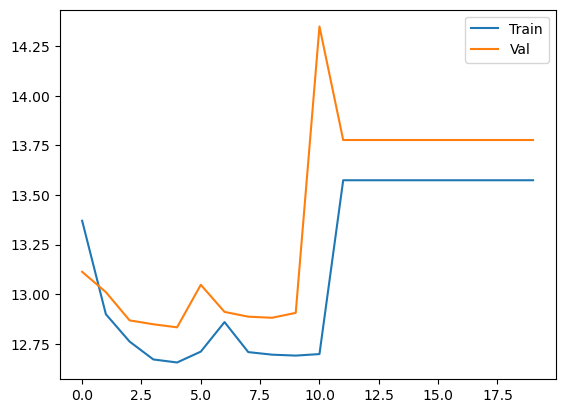

In [40]:
history_train, history_val = train_function(100)
history_train_list += history_train
history_val_list += history_val
plt.plot(history_train_list[1::5],label="Train")
plt.plot(history_val_list,label="Val")
plt.legend()

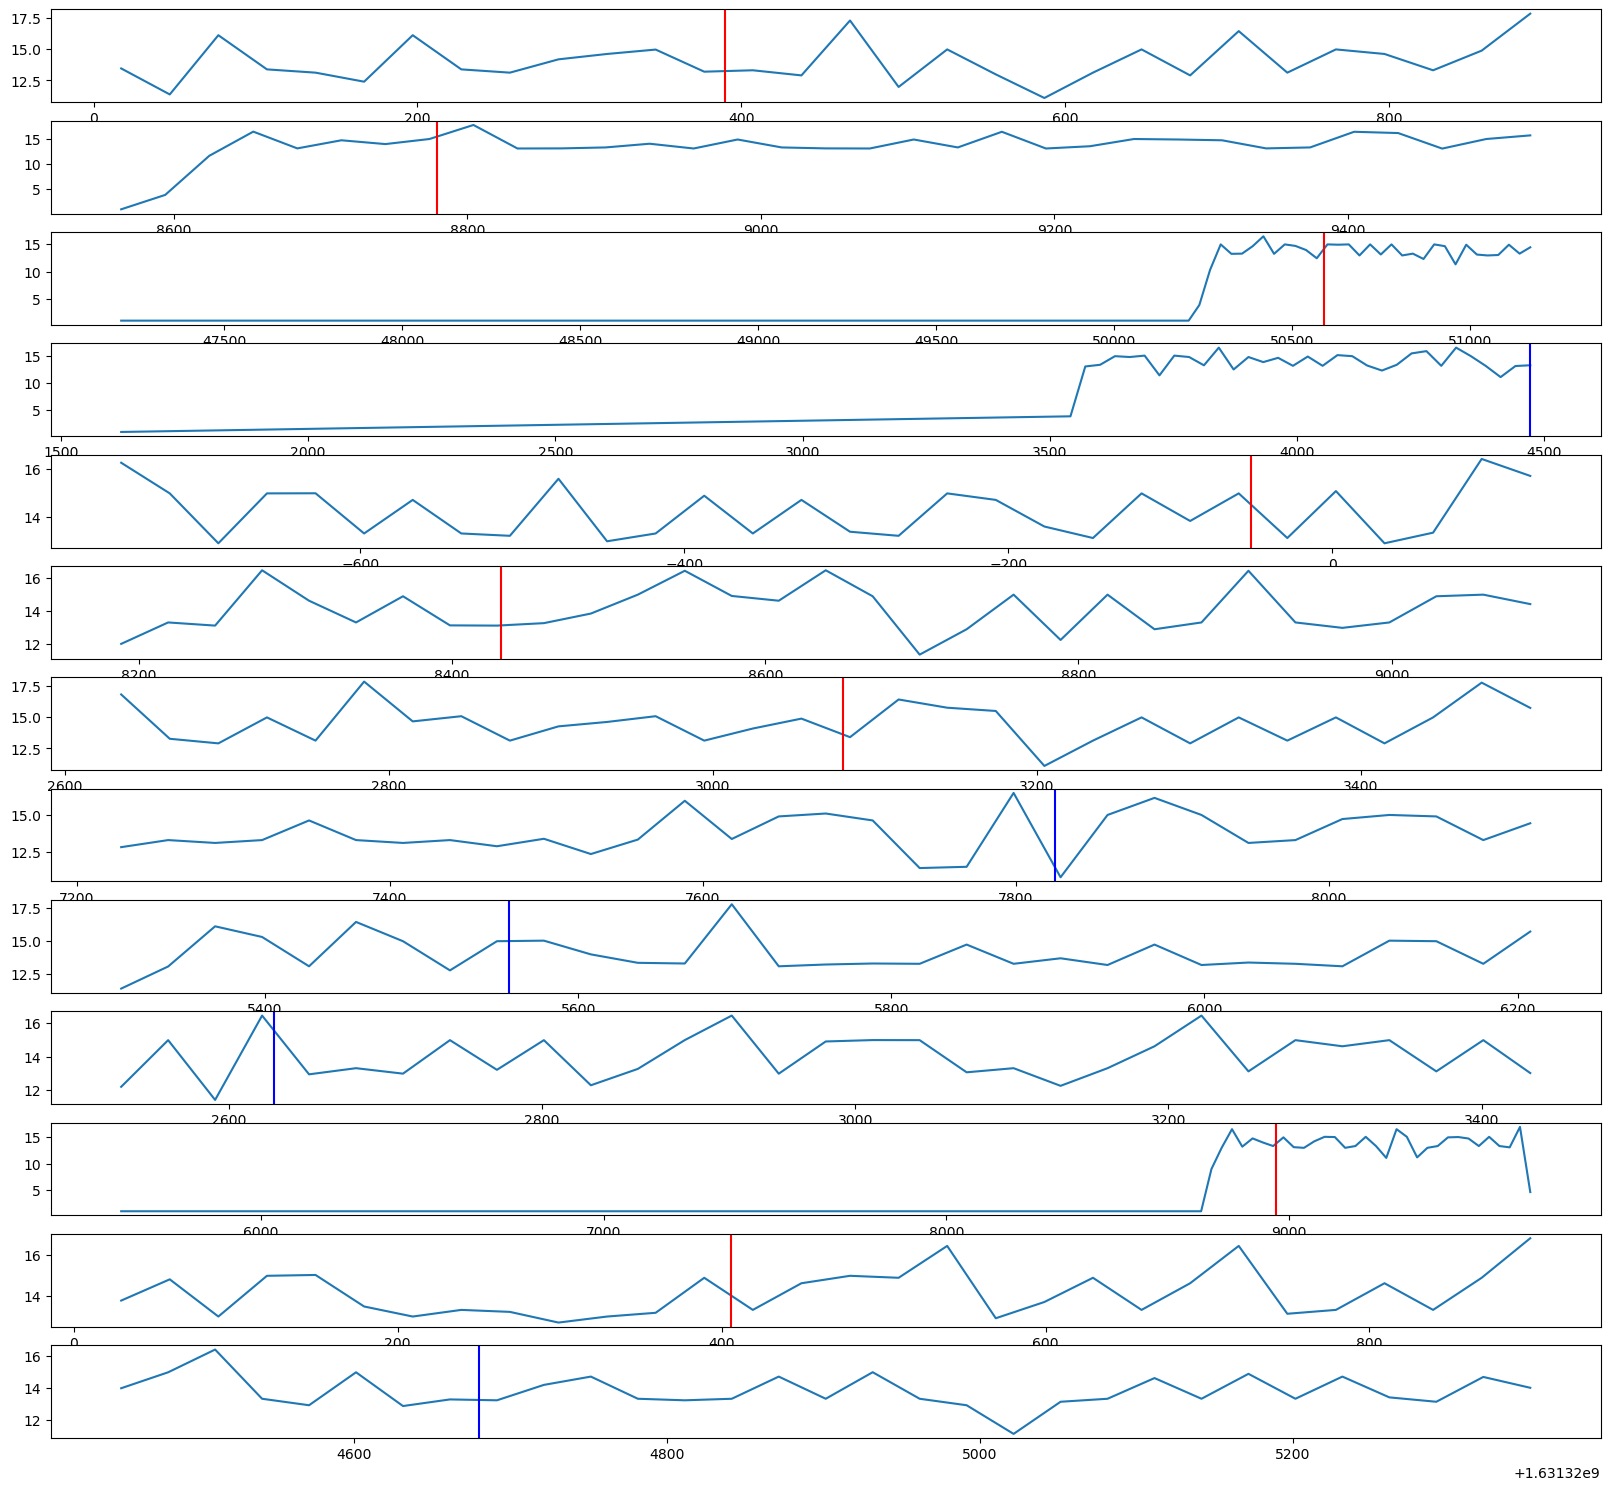

In [41]:
fig = plt.figure(figsize=(20,20))    
for i_signal,(signal, adj_list, annotation) in enumerate(zip(signals_val,adj_list_val, annotation_val)):
    snapshot_losses = test_loop(signal, model, loss_f, optimizer, device, adj_list)
#                 print(np.mean(val_loss))
#     val_losses.append(np.mean(snapshot_losses))
    ts_list = signal.ts_list
    plt.subplot(len(signals_val)+1,1,i_signal+1)
#     print(len(snapshot_losses))
    plt.plot(ts_list,snapshot_losses)
    if annotation[0] == 'dos':
        plt.axvline(x = float(annotation[1]), color = 'red', label = annotation[0])
    if annotation[0] == 'privesc':
        plt.axvline(x = float(annotation[1]), color = 'blue', label = annotation[0])
# plt.show()
# plt.savefig(f'val_res_TGAE_NNConv_{GLOBAL_EPOCH}_{np.mean(history_train_list[-1]):.4f}_{np.mean(history_val_list[-1]):.4f}.png')

In [42]:
torch.save(model,f"TGAE_NNConv_{GLOBAL_EPOCH}_{np.mean(history_train_list[-1]):.4f}_{np.mean(history_val_list[-1]):.4f}.model")

# Evaluation

In [43]:
snapshot_losses_list = []
for i_signal,(signal,y) in enumerate(zip(signals_val,y_val)):
    snapshot_losses = test_loop(signal, model, loss_f, optimizer, device)
    snapshot_losses_list.append(snapshot_losses)

TypeError: test_loop() missing 1 required positional argument: 'adj_list'

In [ ]:
for snapshot_losses, y in zip(snapshot_losses_list,y_val):
#     print(snapshot_losses)
    print([(i_snapshot, len(loss),int(label)) for i_snapshot, (loss, label) in enumerate(zip(snapshot_losses, y))])
    loss_list = []
    for losses in snapshot_losses:
        loss_list += list(losses)
    counts, edges, bars = plt.hist(loss_list)
    plt.bar_label(bars)
    plt.show()
    break
    

In [ ]:
counts, edges, bars = plt.hist(snapshot_losses_list[0][1])
plt.bar_label(bars)
plt.show()

In [ ]:
counts, edges, bars = plt.hist(snapshot_losses_list[0][11])
plt.bar_label(bars)
plt.show()

In [ ]:
# history_train, history_val = train_function(50)
# history_train_list += history_train
# history_val_list += history_val
# plt.plot(history_train_list[1::5],label="Train")
# plt.plot(history_val_list,label="Val")
# plt.legend()

In [ ]:
# fig = plt.figure(figsize=(20,20))    
# for i_signal,(signal,y) in enumerate(zip(signals_val,y_val)):
#     snapshot_losses = test_loop(signal, model, loss_f, optimizer, device)
# #                 print(np.mean(val_loss))
# #     val_losses.append(np.mean(snapshot_losses))
#     ts_list = signal.ts_list
#     plt.subplot(len(signals_val)+1,1,i_signal+1)
# #     print(len(snapshot_losses))
#     plt.plot(ts_list,[np.max(loss) for loss in snapshot_losses])
#     if y[0] == 'dos':
#         plt.axvline(x = float(y[1]), color = 'red', label = y[0])
#     if y[0] == 'privesc':
#         plt.axvline(x = float(y[1]), color = 'blue', label = y[0])
# # plt.show()
# plt.savefig(f'val_res_TGAE_NNConv_{GLOBAL_EPOCH}_{np.mean(history_train_list[-1]):.4f}_{np.mean(history_val_list[-1]):.4f}.png')

In [ ]:
# with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], use_cuda=True, record_shapes=True) as prof:
#         history_train, history_val = train_function(1)
#         history_train_list += history_train
#         history_val_list += history_val
#         plt.plot(history_train_list[1::5],label="Train")
#         plt.plot(history_val_list,label="Val")
#         plt.legend()
# print(prof.key_averages().table(sort_by="cuda_time_total"))

In [ ]:
# print(prof.key_averages().table(sort_by="cpu_time_total"))

In [ ]:
# fig = plt.figure(figsize=(20,20))    
# for i_signal,(signal,y) in enumerate(zip(signals_val,y_val)):
#     snapshot_losses = test_loop(signal, model, loss_f, optimizer, device)
# #                 print(np.mean(val_loss))
# #     val_losses.append(np.mean(snapshot_losses))
#     ts_list = signal.ts_list
#     plt.subplot(len(signals_val)+1,1,i_signal+1)
# #     print(len(snapshot_losses))
#     plt.plot(ts_list,snapshot_losses[:-1])
#     if y[0] == 'dos':
#         plt.axvline(x = float(y[1]), color = 'red', label = y[0])
#     if y[0] == 'privesc':
#         plt.axvline(x = float(y[1]), color = 'blue', label = y[0])
# # plt.show()
# plt.savefig('val_res.png')

In [ ]:
# torch.save(model,f"{GLOBAL_EPOCH}_{np.mean(history_train_list[-1]):.4f}_{np.mean(history_val_list[-1]):.4f}.model")

In [ ]:
# history_train, history_val = train_function(100)
# history_train_list += history_train
# history_val_list += history_val
# plt.plot(history_train_list[1::5],label="Train")
# plt.plot(history_val_list,label="Val")
# plt.legend()

In [ ]:
# states_encoder_val = []
# states_decoder_val = []
# for num_node in nums_node_val:
#     states_encoder_val.append(create_hidden_global(num_node=num_node,out_channels=model.gnn_out_channels))
#     states_decoder_val.append(create_hidden_global(num_node=num_node,out_channels=model.embedding_hidden_nums[-1]))    

# fig = plt.figure(figsize=(20,20))    
# for i_sample, (sample, y, hidden_encoder_global, hidden_decoder_global) in enumerate(zip(X_val, y_val, states_encoder_val, states_decoder_val)):
#     val_loss = test_loop(sample, hidden_encoder_global, hidden_decoder_global, model, loss_f, optimizer, device)
#     # print(np.mean(val_loss))
#     ts_list = [snapshot.timestamp for snapshot in sample]
#     plt.subplot(len(X_val)+1,1,i_sample+1)
#     plt.plot(ts_list,val_loss)
#     if y[0] == 'dos':
#         plt.axvline(x = float(y[1]), color = 'red', label = y[0])
#     if y[0] == 'privesc':
#         plt.axvline(x = float(y[1]), color = 'blue', label = y[0])
# plt.show()